# Q-Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import gym.spaces
import time
import copy
import threading
import time
import collections
from IPython.display import clear_output

## Basic Environment

In [2]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': ['human'] }
    
    def __init__(self, normalize=False, size=4):
        self.observation_space = gym.spaces.Box(0, size, (size,))
        self.action_space = gym.spaces.Discrete(4)
        self.max_timesteps = size*2 + 1
        self.normalize = normalize
        self.size = size

        # Generate State Transition Table
        self.transition_matrix = []
        for x in range(size + 1):
            state_x = []
            for y in range(size + 1):
                state_y = []
                for a in range(4):
                    one_hot = np.zeros(4)
                    one_hot[a] = 1
                    state_y.append(one_hot)
                state_x.append(state_y)
            self.transition_matrix.append(state_x)
        
    def transition_func(self, x, y, action, return_probs=False):
        probs = self.transition_matrix[x][y][action]
        if return_probs:
            return probs
        else:
            return np.random.choice(len(probs), p=probs)

    def _get_distance(self, x, y):
        return abs(x[0] - y[0]) + abs(x[1] - y[1])
        
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [self.size, self.size]
        self.state = np.zeros((self.size + 1, self.size + 1))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.prev_distance = self._get_distance(self.agent_pos, self.goal_pos)
        return np.array(self.agent_pos)/1.
    
    def step(self, action):
        action_taken = self.transition_func(self.agent_pos[0], self.agent_pos[1], action)
        self.state = np.random.choice(self.observation_space.shape[0])
        if action_taken == 0:
            self.agent_pos[0] += 1
        if action_taken == 1:
            self.agent_pos[0] -= 1
        if action_taken == 2:
            self.agent_pos[1] += 1
        if action_taken == 3:
            self.agent_pos[1] -= 1
          
        self.agent_pos = np.clip(self.agent_pos, 0, self.size)
        self.state = np.zeros((self.size + 1, self.size + 1))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        
        current_distance = self._get_distance(self.agent_pos, self.goal_pos)
        if current_distance < self.prev_distance:
            reward = 1
        elif current_distance > self.prev_distance:
            reward = -1
        else:
            reward = -1
        self.prev_distance = current_distance
        
        self.timestep += 1
        if self.timestep >= self.max_timesteps or current_distance == 0:
            done = True
        else:
            done = False
        info = {}
        
        obs = self.agent_pos
        if self.normalize:
            obs = obs/self.size
        return obs, reward, done, info
        
    def render(self, mode='human'):
        plt.imshow(self.state)

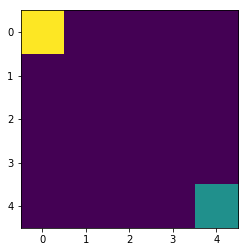

In [3]:
env = GridEnvironment()
obs = env.reset()
env.render()

## Random Agent

In [4]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def policy(self, observation):
        return np.random.choice(self.action_space.n)
        
    def step(self, observation, verbose=False):
        return self.policy(observation)

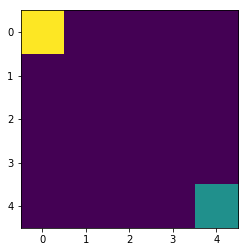

In [5]:
env = GridEnvironment(normalize=True)
agent = RandomAgent(env)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs, verbose=True)
    obs, reward, done, info = env.step(action)
    clear_output(True)
    env.render()
    plt.show()

## Heuristic Agent

In [6]:
class HeuristicAgent:
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def policy(self, observation):
        # 0 - down
        # 1 - up
        # 2 - right
        # 3 - left
        if (observation[0] < 1.):
            return 0
        if (observation[1] < 1.):
            return 2
        return 0
        
    def step(self, observation, verbose=False):
        if verbose:
            print(observation)
        return self.policy(observation)

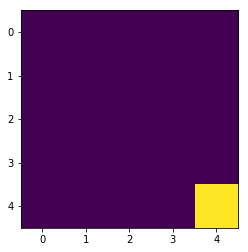

In [7]:
env = GridEnvironment(normalize=True)
agent = HeuristicAgent(env)

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.show()

while not done:
    action = agent.step(obs, verbose=True)
    obs, reward, done, info = env.step(action)
    clear_output(True)
    env.render()
    plt.show()

## Tabular Q-Learning

### Epsilon

Our agent will randomly select its action at first by a certain percentage, called ‘exploration rate’ or ‘epsilon’. This is because at first, it is better for the agent to try all kinds of things before it starts to see the patterns. When it is not deciding the action randomly, the agent will predict the reward value based on the current state and pick the action that will give the highest reward. We want our agent to decrease the number of random action, as it goes, so we indroduce an exponential-decay epsilon, that eventually will allow our agent to explore the evironment. \\



###  <font color='red'>Implementing policy function.</font>  <br>
- Our agent will randomly select its action at first by a certain percentage, called ‘exploration rate’ or ‘epsilon’. This is because at first, it is better for the agent to try all kinds of things before it starts to see the patterns. Select a random uniform number. If it's less than epsilon, return the random choice action space.
- When it is not deciding the action randomly, the agent will predict the reward value based on the current state and pick the action that will give the highest reward. 
\begin{align} \notag
\pi\left(s_{t}\right)=\underset{a \in A}{\operatorname{argmax}} Q_{\theta}\left(s_{t}, a\right)
\end{align} 
- Return the policy

epsilon $\rightarrow$ self.epsilon </br> 
action_space $\rightarrow$ self.action_space

###  <font color='red'>Update Q-table</font>  <br>
\begin{align} \notag
Q^{n e w}\left(s_{t}, a_{t}\right) \leftarrow(1-\alpha) \cdot \underbrace{Q\left(s_{t}, a_{t}\right)}_{\text {old value }}+\underbrace{\alpha}_{\text {learning rate }} \cdot \overbrace{(\underbrace{r_{t}}_{\text {reward }} + \underbrace{\gamma}_{\text {discount factor }} \underbrace{\max _{a} Q\left(s_{t+1}, a\right)}_{a})}^{\text {learned value }}
            \end{align} 

In [26]:
class QLearningAgent:
    def __init__(self, env, epsilon=1.0, lr=0.1, gamma=0.9):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        q_table_dim = env.observation_space.shape[0] + 1
        self.q_table = np.zeros((q_table_dim, q_table_dim, env.action_space.n))
        self.epsilon = epsilon
        self.lr = lr
        self.gamma = gamma

    def policy(self, observation):
      # Code for policy (Task 1) (30 points)
    
        max_q = 0
        action = ""
        #generate random action according to the epsilon greedy strategy
        if np.random.uniform(0, 1) <= self.epsilon:
            action = np.random.choice(self.action_space.n)
        else:
            for act in range(self.action_space.n):
                new_q = self.q_table[int(observation[0])][int(observation[1])][act]
                if new_q >= max_q:
                    action = act
                    max_q = new_q
        return action

    def step(self, observation):
        return self.policy(observation)

    def update(self, state, action, reward, next_state):
        state = state.astype(int)
        next_state = next_state.astype(int)
        
        # Code for updating Q Table (Task 2) (20 points)
        prev_q_val = self.q_table[state[0]][state[1]][action]
        max_q_val = np.amax(self.q_table[next_state[0]][next_state[1]])
        next_q_val = (1 - self.lr) * prev_q_val + self.lr * (reward + self.gamma * max_q_val)
        self.q_table[state[0]][state[1]][action] = next_q_val

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

### Training

Episode: 99
State: [4 4]


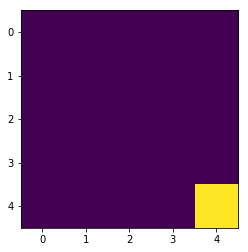

In [27]:
env = GridEnvironment() # note: we do not normalize
agent = QLearningAgent(env)
episodes = 100 # number of games we want the agent to play
delta_epsilon = agent.epsilon/episodes
decay_rate = 0.9

total_rewards = []
epsilons = [agent.epsilon]

# Training Process (Task 3) (20 points)
for i in range(episodes):
    observation = env.reset()
    done = False
    curr_state = observation.copy()
    rewards = 0
    while not done:
        
        clear_output(True)
        print("Episode:",i)
        print("State:", curr_state)
        env.render()
        plt.show()
        time.sleep(0.03)
        
        action = agent.step(curr_state)
        observation, reward, done, info = env.step(action)
        next_state = observation.copy()
        agent.update(curr_state, action, reward, next_state)
        curr_state = next_state.copy()
        rewards += reward
        
        clear_output(True)
        print("Episode:",i)
        print("State:", curr_state)
        env.render()
        plt.show()
        time.sleep(0.03)
        
    #Exponential Decay Epsilon
    #As delta_epsilon is too low for exponential decay, so using a higher decay rate instead
    new_epsilon = agent.epsilon * decay_rate  #agent.epsilon * delta_epsilon
    agent.set_epsilon(new_epsilon)
    epsilons.append(new_epsilon)
    
    total_rewards.append(rewards)


#### Visualize $\epsilon$
Plot our value of $\epsilon$ over each episode

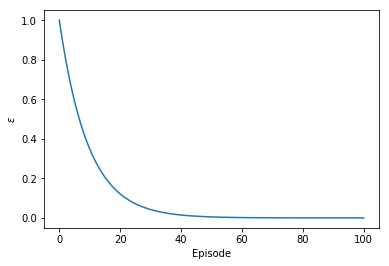

In [17]:
plt.xlabel('Episode')
plt.ylabel('$\epsilon$')
plt.plot(epsilons)

#### Visualize Rewards

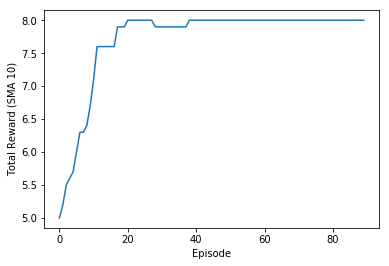

In [18]:
window = 10
plt.xlabel('Episode')
plt.ylabel('Total Reward (SMA 10)')
plt.plot([np.mean(total_rewards[tr:tr+window]) for tr in range(window, len(total_rewards))])

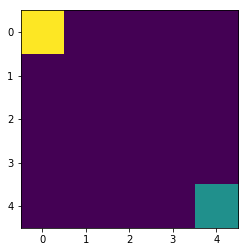

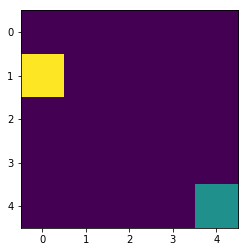

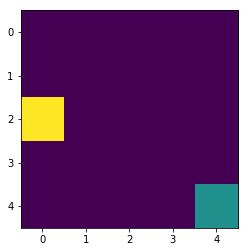

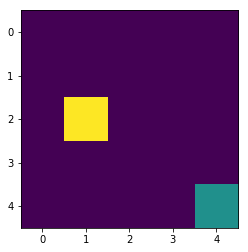

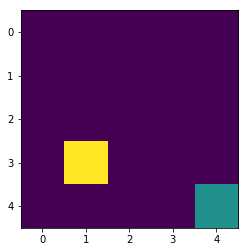

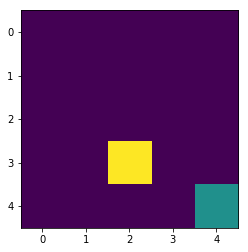

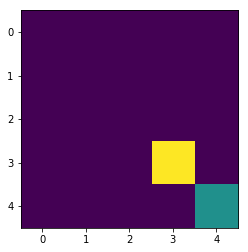

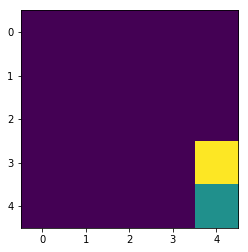

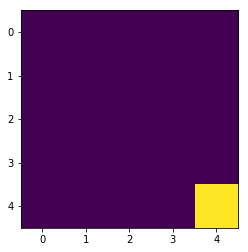

In [25]:
env = GridEnvironment()

obs = env.reset()
done = False
agent.epsilon = 0
env.render()
plt.ion()
plt.show()

while not done:
    action = agent.step(obs)
    obs, reward, done, info = env.step(action)
    env.render()
    plt.show()
    plt.pause(0.05)

## The agent follows an optimal policy in which takes 8 steps to reach from Source to Desination